# 00 - Preparation

In [24]:
import warnings
warnings.filterwarnings('ignore')

Define Output Directory

In [25]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/arc/analyses/arc_atrophy_spcorr'

# 01 - Imports

**A) Import Niftis from Folders**

**Import The First Matrix**

Enter Folder or CSV Containing Files

In [26]:
# Path to folder or CSV with files. 
import_path = r'/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/arc/analyses/age_corr_to_atrophy'
# Ff Importing a CSV
file_pattern = r'*.nii'
# If Importing a Folder
file_column = ''

Run Import

In [27]:
from calvin_utils.file_utils.import_functions import GiiNiiFileImport
matrix_df1 = GiiNiiFileImport(import_path=import_path, file_column=file_column, file_pattern=file_pattern).run()
matrix_df1

Attempting to import from: /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/arc/analyses/age_corr_to_atrophy/*.nii


,uncorrected_results.nii,p_values.nii,fwe_corrected_results.nii
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
902624,0.0,0.0,0.0
902625,0.0,0.0,0.0
902626,0.0,0.0,0.0
902627,0.0,0.0,0.0


**Optional: Import Additional Matrices Second Matrix**

Enter Information Relating to the Path of the First Set of Niftis

In [28]:
# Path to folder or CSV with files. 
import_path = r'/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/arc/analyses/arc'
# Ff Importing a CSV
file_pattern = r'*.nii'
# If Importing a Folder
file_column = ''

Import

In [29]:
from calvin_utils.file_utils.import_functions import GiiNiiFileImport
matrix_df2 = GiiNiiFileImport(import_path=import_path, file_column=file_column, file_pattern=file_pattern).run()
matrix_df2

Attempting to import from: /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/arc/analyses/arc/*.nii


,ARC_gene_expression.nii,arc_peak_34_-34_-4_connectivity.nii,Memory Network T Conn.nii
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
902624,0.0,0.0,0.0
902625,0.0,0.0,0.0
902626,0.0,0.0,0.0
902627,0.0,0.0,0.0


Merge Dataframes

In [30]:
from calvin_utils.nifti_utils.matrix_utilities import join_dataframes
try:
    merged_df = join_dataframes(matrix_df1, matrix_df2)
except:
    print('Matrix DF2 does not exist. Just using DF1')
    merged_df = matrix_df1
merged_df

df1 len:  902629  matrix_df2 len:  902629
Nonzero values in last column:  292019


,uncorrected_results.nii,p_values.nii,fwe_corrected_results.nii,ARC_gene_expression.nii,arc_peak_34_-34_-4_connectivity.nii,Memory Network T Conn.nii
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
902624,0.0,0.0,0.0,0.0,0.0,0.0
902625,0.0,0.0,0.0,0.0,0.0,0.0
902626,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0


# 02 - Masking

In [31]:
import numpy as np
from nimlab import datasets as nimds
from nilearn import image

def apply_mask_to_dataframe(merged_df, mask_path=None):
    """
    Apply a mask to a dataframe using either a provided mask or the default MNI ICBM152 mask.
    
    Parameters:
    - merged_df (DataFrame): The dataframe to which the mask should be applied.
    - mask_path (str, optional): The path to the mask image. If not provided, the MNI ICBM152 mask will be used.
    
    Returns:
    - DataFrame: The masked dataframe containing only the rows specified by the mask.
    
    Example usage:
    >>> masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
    """
    
    # Load the mask data based on the provided mask_path or use default mask
    if mask_path is not None:
        brain_indices = np.where(image.load_img(mask_path).get_fdata().flatten() > 0)[0]
    else:
        mni_mask = nimds.get_img("mni_icbm152")
        mask_data = mni_mask.get_fdata().flatten()
        brain_indices = np.where(mask_data > 0)[0]
    
    # Apply the mask to the dataframe
    masked_df = merged_df.iloc[brain_indices]
    
    return masked_df




In [32]:
masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
masked_df


,uncorrected_results.nii,p_values.nii,fwe_corrected_results.nii,ARC_gene_expression.nii,arc_peak_34_-34_-4_connectivity.nii,Memory Network T Conn.nii
93491,-0.034826,1.000,0.000000,0.401947,-0.002587,7.034553
93492,-0.082324,1.000,0.000000,0.445889,-0.001177,4.939664
93493,-0.137641,0.015,-0.137641,0.454977,-0.001852,1.760241
93582,-0.050853,1.000,0.000000,0.427408,-0.000460,7.857507
93583,-0.117339,0.456,0.000000,0.472968,-0.001516,5.583203
...,...,...,...,...,...,...
798193,0.011290,1.000,0.000000,0.362900,0.010808,27.091604
798281,-0.021078,1.000,0.000000,0.240784,0.008802,27.270569
798282,0.024990,1.000,0.000000,0.230858,0.012962,28.221195
798283,0.022050,1.000,0.000000,0.364319,0.014416,28.994501


Transform the Data

In [33]:
# masked_df = masked_df.abs()
# masked_df[masked_df < 3] = 0 
# masked_df.max()



Sort The Dataframe

In [34]:
from natsort import natsorted
masked_df = masked_df.reindex(columns=natsorted(masked_df.columns))

# 03 - Spatial Correlation

**Perform Correlation**

method_choices:
- 0 = pearson
- 1 = spearman
- 2 = kendall

Only_compare_nonzero_voxels:
- We have already removed brain-external values by masking
- This will simply prevent comparison of voxels that are not present in both maps.

In [35]:
method_choice = 1
only_compare_nonzero_voxels=True

In [36]:
import pandas as pd
from tqdm import tqdm
from natsort import natsorted

def compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=False):
    """
    Compute correlations among columns of a DataFrame using a specified method.
    When only_compare_nonzero_voxels is True, only pairs of non-zero voxels are used for the computation.
    
    Parameters:
    - df (DataFrame): The dataframe for which correlations should be computed.
    - method_choice (int, optional): An integer indicating the correlation method to be used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    - only_compare_nonzero_voxels (bool, optional): Flag to determine whether to compute correlations 
                                                    considering only non-zero voxels. Default is False.
    
    Returns:
    - DataFrame: The correlation matrix.
    
    Example usage:
    >>> corr_matrix = compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=True)
    """
    
    methods = ['pearson', 'spearman', 'kendall']
    method = methods[method_choice]
    
    # If only_compare_nonzero_voxels is False, compute the correlation in the usual manner
    if not only_compare_nonzero_voxels:
        return df.corr(method=method), method
    else:
        columns = df.columns
        n = len(columns)
        
        # Initialize a dataframe to store the results
        corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
        
        # Iterate over each pair of columns
        for i in tqdm(range(n)):
            for j in range(i, n):
                # Filter rows where both columns have non-zero values
                temp_df = df[(df[columns[i]] != 0) & (df[columns[j]] != 0)]
                
                # Compute correlation for the filtered rows
                corr_value = temp_df[[columns[i], columns[j]]].corr(method=method).iloc[0, 1]
                
                # Assign the computed value to the result dataframe
                corr_df.iloc[i, j] = corr_value
                corr_df.iloc[j, i] = corr_value
                
    #Sort the Dataframe            
    corr_df = corr_df.reindex(index=natsorted(corr_df.index))
    corr_df = corr_df.reindex(columns=natsorted(corr_df.columns))
    return corr_df, method

import os

def save_correlation_results(corr_df, fig, out_dir, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    methods = ['spatial_pearson', 'spatial_spearman', 'spatial_kendall']
    method_choice = methods[method_choice]
    if save:
        out_dir = os.path.join(out_dir, 'spatial_correlation')
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))

In [37]:
corr_df, method = compute_correlation(masked_df, method_choice=method_choice, 
                                      only_compare_nonzero_voxels=only_compare_nonzero_voxels)
corr_df

100%|██████████| 6/6 [00:00<00:00, 11.33it/s]


,ARC_gene_expression.nii,Memory Network T Conn.nii,arc_peak_34_-34_-4_connectivity.nii,fwe_corrected_results.nii,p_values.nii,uncorrected_results.nii
ARC_gene_expression.nii,1.000000,-0.197786,-0.124926,0.127907,0.009040,0.071986
Memory Network T Conn.nii,-0.197786,1.000000,0.671202,-0.122791,-0.028887,-0.096743
arc_peak_34_-34_-4_connectivity.nii,-0.124926,0.671202,1.000000,-0.245816,-0.066599,-0.191843
fwe_corrected_results.nii,0.127907,-0.122791,-0.245816,1.000000,0.995056,1.000000
p_values.nii,0.009040,-0.028887,-0.066599,0.995056,1.000000,0.611290
uncorrected_results.nii,0.071986,-0.096743,-0.191843,1.000000,0.611290,1.000000


**Visualize the Correlation Matrix**

saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/arc/analyses/arc_atrophy_spcorr/spatial_correlation/spatial_spearman_correlation_matrix.png


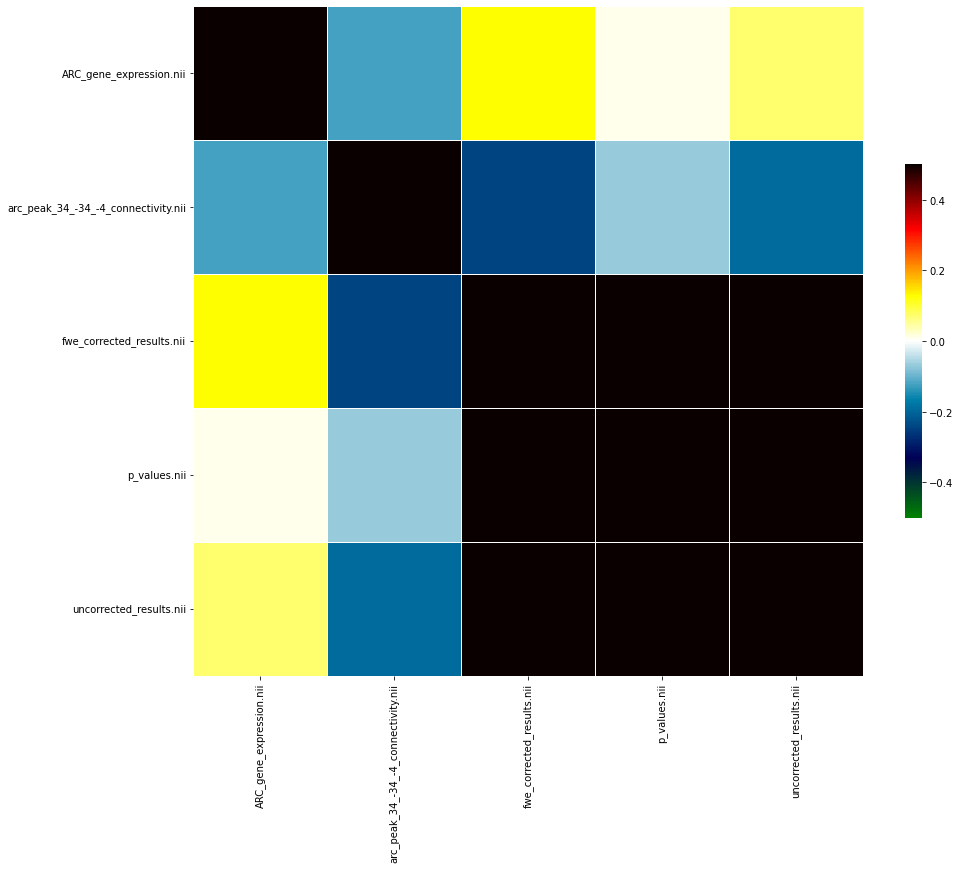

In [17]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-0.5, vmax=0.5)       
save_correlation_results(corr_df=corr_df, fig=fig, out_dir=out_dir, save=True, method_choice=method_choice)   

**Show Specific Heatmap**

In [ ]:
print(corr_df.columns)

In [ ]:
#Enter networks of interest
network_of_interest = '150_vat_seed_compound_fMRI_efield_func_seed_T.nii'
networks_of_disinterest = [
    None   
]

#---isolate network of interest and remove those not of interest
corr_df_2 = corr_df.copy()
corr_df_2 = pd.DataFrame(corr_df_2.loc[:, network_of_interest])
if networks_of_disinterest[0] is not None:
    for network in networks_of_disinterest:
        corr_df_2.drop(network, inplace=True)
#Sort the dataframe by descending order
corr_df_2 = corr_df_2.sort_values(network_of_interest)
#Remove .nii from file names
for name in corr_df_2.columns.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='columns')
for name in corr_df_2.index.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='index')

#---Visualize the new data
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))

sns.heatmap(corr_df_2, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

#Save results
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.png')
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.svg')
corr_df_2.to_csv(out_dir + f'/spcorrel_{network_of_interest}.csv')
display(corr_df_2)
print(out_dir)

**Extract the Cross-Correlation Matrix**

In [ ]:
def extract_cross_correlation_diagonal(corr_df):
    """
    Extracts the diagonal of the cross-correlation from the given correlation matrix.
    
    Parameters:
    - corr_df (DataFrame): The correlation matrix.
    
    Returns:
    - DataFrame: The diagonal of the cross-correlation with the patient identifiers as the index.
    
    Example usage:
    >>> cross_corr_diag = extract_cross_correlation_diagonal(corr_df)
    """
    
    # Assuming the dataframe is square and has an even number of columns,
    # split it into two equal parts
    n = len(corr_df)
    half_n = n // 2
    
    # Extract the values from the intersection of the rows of the first dataset 
    # and the columns of the second dataset
    cross_corr_values = [corr_df.iloc[i, i + half_n] for i in range(half_n)]
    
    # Convert to DataFrame while maintaining the index from the original corr_df
    cross_corr_df = pd.DataFrame(cross_corr_values, index=corr_df.index[:half_n], columns=["Cross-Correlation"])
    
    return cross_corr_df



In [ ]:
cross_corr_diagonal_df = extract_cross_correlation_diagonal(corr_df)
cross_corr_diagonal_df

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(cross_corr_diagonal_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)       

Save Results

In [ ]:
import os

def save_cross_correlation_results(corr_df, fig, out_dir, comparison, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    
    if save:
        out_dir = os.path.join(out_dir, comparison)
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_cross_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))

In [ ]:
save_results = True

In [ ]:
save_cross_correlation_results(corr_df=cross_corr_diagonal_df, fig=fig, out_dir=out_dir, comparison=comparison, save=save_results, method_choice=method_choice)

# 04 - Permute Spatial Correlation

In [ ]:
import pandas as pd
from tqdm import tqdm
from natsort import natsorted
import numpy as np

class PermutedSpatialCorrelation:
    def __init__(self, dataframe, n_permutations=1000):
        self.dataframe = dataframe
        self.n_permutations = n_permutations
        self.permuted_correlations = []
        self.observed_correlation = None

    def compute_correlation(self, df, method_choice=0, only_compare_nonzero_voxels=False):
        """
        Compute correlations among columns of a DataFrame using a specified method.
        When only_compare_nonzero_voxels is True, only pairs of non-zero voxels are used for the computation.
        
        Parameters:
        - df (DataFrame): The dataframe for which correlations should be computed.
        - method_choice (int, optional): An integer indicating the correlation method to be used. 
                                        0: Pearson (default), 1: Spearman, 2: Kendall.
        - only_compare_nonzero_voxels (bool, optional): Flag to determine whether to compute correlations 
                                                        considering only non-zero voxels. Default is False.
        
        Returns:
        - DataFrame: The correlation matrix.
        
        Example usage:
        >>> corr_matrix = compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=True)
        """
        
        methods = ['pearson', 'spearman', 'kendall']
        method = methods[method_choice]
        
        # If only_compare_nonzero_voxels is False, compute the correlation in the usual manner
        if not only_compare_nonzero_voxels:
            return df.corr(method=method), method
        else:
            columns = df.columns
            n = len(columns)
            
            # Initialize a dataframe to store the results
            corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
            
            # Iterate over each pair of columns
            for i in tqdm(range(n)):
                for j in range(i, n):
                    # Filter rows where both columns have non-zero values
                    temp_df = df[(df[columns[i]] != 0) & (df[columns[j]] != 0)]
                    
                    # Compute correlation for the filtered rows
                    corr_value = temp_df[[columns[i], columns[j]]].corr(method=method).iloc[0, 1]
                    
                    # Assign the computed value to the result dataframe
                    corr_df.iloc[i, j] = corr_value
                    corr_df.iloc[j, i] = corr_value
                    
        #Sort the Dataframe            
        corr_df = corr_df.reindex(index=natsorted(corr_df.index))
        corr_df = corr_df.reindex(columns=natsorted(corr_df.columns))
        return corr_df, method


    def permute_column(self, column):
        return np.random.permutation(column)

    def permute_and_correlate(self):
        permuted_df = self.dataframe.copy()
        for col in permuted_df.columns:
            permuted_df[col] = self.permute_column(permuted_df[col])
        permuted_corr, _ = self.compute_correlation(permuted_df)
        return permuted_corr

    def run_permutations(self):
        self.observed_correlation, _ = self.compute_correlation(self.dataframe)
        for _ in tqdm(range(self.n_permutations)):
            permuted_corr = self.permute_and_correlate()
            self.permuted_correlations.append(permuted_corr)

    def compute_p_value(self):
        if self.observed_correlation is None:
            raise ValueError("Run permutations first to compute observed correlation.")
        p_values = pd.DataFrame(index=self.dataframe.columns, columns=self.dataframe.columns)
        for i, col_i in enumerate(self.dataframe.columns):
            for j, col_j in enumerate(self.dataframe.columns):
                bool_array = [permuted_corr.iloc[i, j] > self.observed_correlation.iloc[i, j]
                              for permuted_corr in self.permuted_correlations]
                p_values.iloc[i, j] = np.mean(bool_array)
        return p_values

    def run(self):
        self.run_permutations()
        p_values = self.compute_p_value()
        return p_values, self.observed_correlation

# Usage:
# Create an instance of the class
# psc = PermutedSpatialCorrelation(dataframe, n_permutations=1000)
# p_values, observed_corr = psc.run()

In [ ]:
psc = PermutedSpatialCorrelation(masked_df, n_permutations=10000)
p_values, observed_corr = psc.run()
p_values

# Compute Agreement

In [ ]:
def compute_agreement(df, method_choice='dice'):
    """
    Compute agreement among columns of a DataFrame using a specified method.
    
    Parameters:
    - df (DataFrame): The dataframe for which agreement should be computed.
    - method_choice (str, optional): A string indicating the agreement method to be used. 
                                     'dice': Dice Coefficient, 'jaccard': Jaccard Index, 'percent': % Agreement
    
    Returns:
    - Tuple(DataFrame, DataFrame, DataFrame): Positive agreement matrix, Negative agreement matrix, Overall agreement matrix.
    """
    
    columns = df.columns
    n = len(columns)
    
    # Initialize dataframes to store the results
    pos_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64') if method_choice != 'percent' else None
    neg_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64') if method_choice != 'percent' else None
    overall_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
    
    # Binarize the DataFrame
    bin_df = df.applymap(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    # Iterate over each pair of columns
    for i in range(n):
        for j in range(i, n):
            
            col1, col2 = columns[i], columns[j]
            
            # Indices where both columns have the same sign (either both positive or both negative)
            same_sign = (bin_df[col1] == bin_df[col2]) & (bin_df[col1] != 0)
            
            # Indices where both columns are positive, negative, or any
            both_pos = (bin_df[col1] == 1) & (bin_df[col2] == 1)
            both_neg = (bin_df[col1] == -1) & (bin_df[col2] == -1)
            
            if method_choice == 'dice':
                # Dice Coefficient
                pos_value = 2 * both_pos.sum() / (bin_df[col1].eq(1).sum() + bin_df[col2].eq(1).sum())
                neg_value = 2 * both_neg.sum() / (bin_df[col1].eq(-1).sum() + bin_df[col2].eq(-1).sum())
                
            elif method_choice == 'jaccard':
                # Jaccard Index
                pos_value = both_pos.sum() / ((bin_df[col1] == 1) | (bin_df[col2] == 1)).sum()
                neg_value = both_neg.sum() / ((bin_df[col1] == -1) | (bin_df[col2] == -1)).sum()
                
            elif method_choice == 'percent':
                # % Agreement of voxels sharing the same sign
                overall_value = same_sign.sum() / len(bin_df)
                overall_corr_df.loc[col1, col2] = overall_value
                overall_corr_df.loc[col2, col1] = overall_value
                continue
            
            overall_value = (pos_value + neg_value) / 2
            
            # Update DataFrames
            if pos_corr_df is not None:
                pos_corr_df.loc[col1, col2] = pos_value
                pos_corr_df.loc[col2, col1] = pos_value
            if neg_corr_df is not None:
                neg_corr_df.loc[col1, col2] = neg_value
                neg_corr_df.loc[col2, col1] = neg_value
            overall_corr_df.loc[col1, col2] = overall_value
            overall_corr_df.loc[col2, col1] = overall_value
    
    return pos_corr_df, neg_corr_df, overall_corr_df


Agreement Methods
method  = 'jaccard', 'dice', or 'percent'

In [ ]:
pos_corr_df, neg_corr_df, overall_corr_df = compute_agreement(masked_df, 'dice')

Positive Agreement

In [ ]:
display(pos_corr_df)

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(pos_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

Negative Agreement

In [ ]:
display(neg_corr_df)

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(neg_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

Overall Agreement

In [ ]:
display(overall_corr_df)

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(overall_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

# Specific Sub-Analyses

In [ ]:
merged_df.columns

In [ ]:
from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(masked_df['Memory Network.nii'], masked_df['R-Map.nii'])
# Format p-value to display more decimal places
formatted_p = "{:.10f}".format(p)

print("Correlation coefficient (r):", r)
print("Formatted p-value:", formatted_p)

Run Mantel Test
- Struggles on vectors >15 000 length. 

In [ ]:
vec_1 = 'Cognitive Decline Network.nii'
vec_2 = 'R-Map.nii'

In [ ]:
import numpy as np
from skbio.stats.distance import mantel
from scipy.spatial.distance import pdist, squareform

# Assuming masked_df is your DataFrame and vec_1, vec_2 are column names
vector1 = masked_df[vec_1].to_numpy()
# vector2 = masked_df[vec_2].to_numpy()

# # Convert vectors to distance matrices
distance_matrix_1 = squareform(pdist(vector1.reshape(-1, 1), 'euclidean'))
# distance_matrix_2 = squareform(pdist(vector2.reshape(-1, 1), 'euclidean'))

# # Perform the Mantel test on the distance matrices
# correlation, p_value, _ = mantel(distance_matrix_1, distance_matrix_2, method='pearson', permutations=999)

# print("Correlation:", correlation)
# print("P-value:", p_value)

In [ ]:
vector1